In [3]:
import openvino 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf

In [4]:
for expression in os.listdir(r"C:\Users\DarkM\project dataset\train\train"):
    directory_path = os.path.join(r"C:\Users\DarkM\project dataset\train\train", expression)
    print(expression + " : " + str(len(os.listdir(directory_path))) + " images")

angry : 4015 images
fear : 4102 images
happy : 5265 images
neutral : 5015 images
sad : 4841 images
surprise : 3212 images


In [5]:
img_size = 48
batch_size = 128

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = datagen_train.flow_from_directory(r"C:\Users\DarkM\project dataset\train\train",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_test = ImageDataGenerator(rescale=1./255, 
                                  horizontal_flip=True)

test_generator = datagen_test.flow_from_directory(r"C:\Users\DarkM\project dataset\test\test",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 26448 images belonging to 6 classes.
Found 7125 images belonging to 6 classes.


In [6]:
# Initialising the CNN
model = Sequential()

# 1st Convolution layer
model.add(Conv2D(128,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(256,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('LeakyReLU'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 3rd Convolution layer
model.add(Conv2D(512,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('LeakyReLU'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 5th Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 128)       512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 256)       8

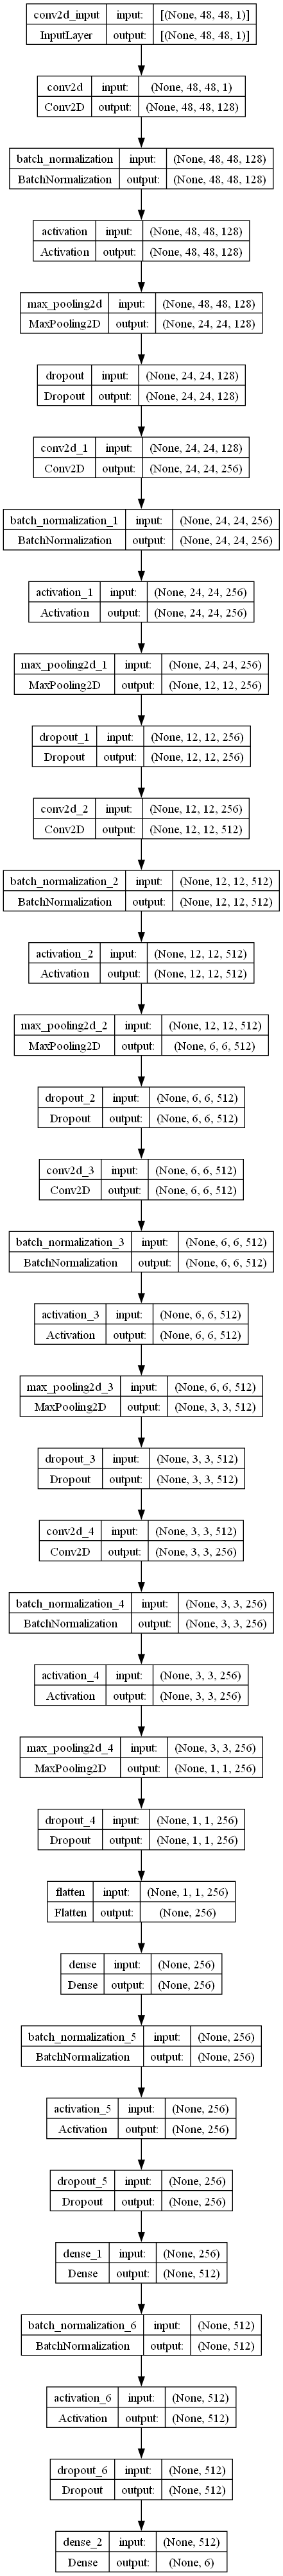

In [7]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

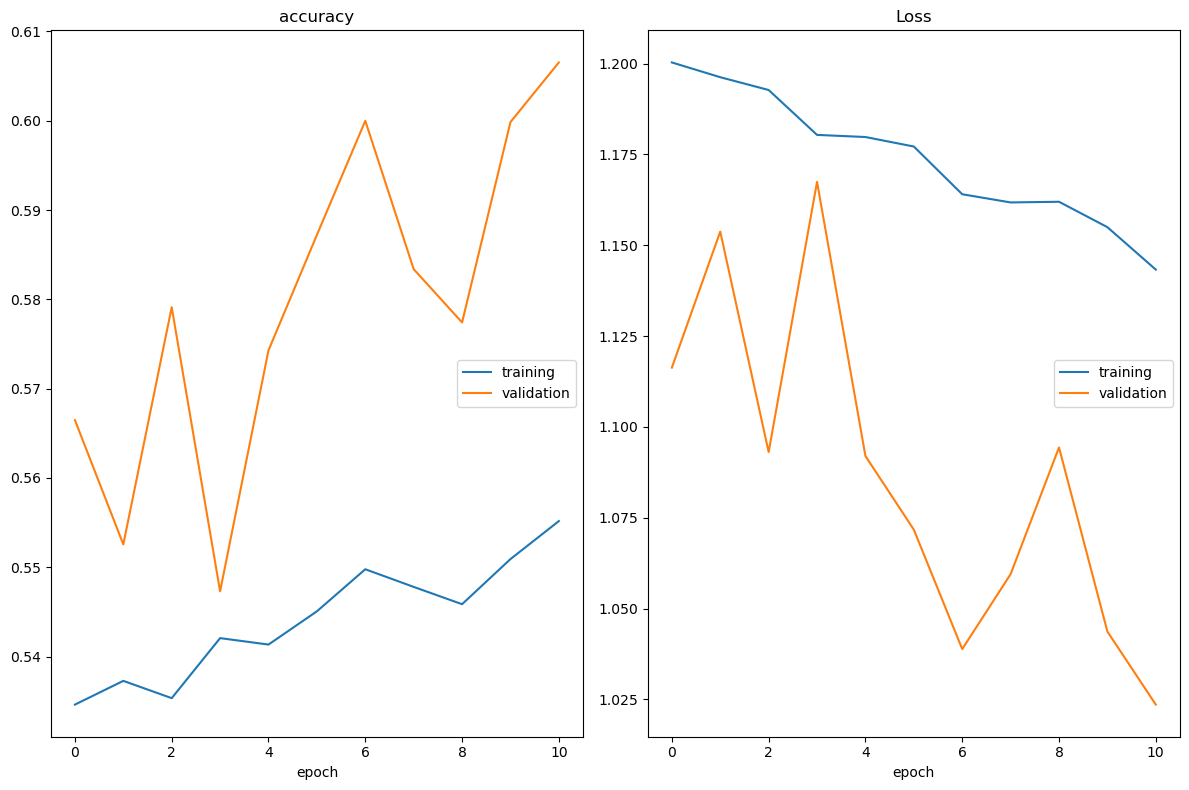

accuracy
	training         	 (min:    0.535, max:    0.555, cur:    0.555)
	validation       	 (min:    0.547, max:    0.607, cur:    0.607)
Loss
	training         	 (min:    1.143, max:    1.200, cur:    1.143)
	validation       	 (min:    1.024, max:    1.167, cur:    1.024)

Epoch 11: saving model to model_weights.h5
206/206 [==============================] - 669s 3s/step - loss: 1.1433 - accuracy: 0.5552 - val_loss: 1.0236 - val_accuracy: 0.6065 - lr: 1.0000e-04
Epoch 12/50
105/206 [==============>...............] - ETA: 5:04 - loss: 1.1346 - accuracy: 0.5596

In [ ]:
%%time

epochs = 50
steps_per_epoch = train_generator.n // train_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_steps,
    callbacks=callbacks
)


In [ ]:
model.save('facial_expression.h5')